In [8]:
import numpy as np
import scipy.optimize as spo
from matplotlib import pyplot as plt   
plt.rcParams['axes.grid'] = True       #Paramètre esthétique, peut être retiré
plt.rcParams['savefig.format'] = 'png' #On peut sélectionner pdf si on aime les images vectorielles

In [9]:
#Ici on importe des données d'un fichier texte, typiquement extraite d'igor, np.loadtxt va charger les données,
#il suffit de lui préciser lechemin à suivre pour trouver le fichier (et transformer tout les \ en \\)
#np.transpose va inverser ligne et colonne pour que Données[k] retourne l'une des colonne de la table igor

Données = np.transpose(np.loadtxt("C:\\Users\\dupuy\\Desktop\\Test.txt"))
Données

array([[1. , 2. , 3. , 4. , 5. , 7. , 8. , 9. ],
       [1. , 2. , 3. , 4. , 5. , 7. , 8. , 9. ],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]])

In [11]:
#On définit ici les abscisses et ordonnées de notre futur graphe. Je part du principe que vous avez pris vos données
#igor et qu'aux 2 premières colonnes on ait les abscisses et les ordonnées, et les deux colonnes suivantes donnent les
#incertitudes sur ces axes. Si c'est différent, il suffit de changer les indices. Potentiellement si c'est pas vos
#données brute que vous représentez, vous pouvez faire des opérations sur les array

x = Données[0]
y = Données[1]
ux= Données[2]
uy= Données[3]

#Pour afficher un point expérimental pris en live, on le définit ici.

x_exp =  np.array([6])
y_exp = np.array([5.5])
ux_exp= np.array([0.1])
uy_exp= np.array([0.1])

#On concatene le point expérimental aux points pris en préparation, pour pouvoir ajuster sur toutes les données. Si 
#vous avez un point aberrant, vous pouvez supprimer ces lignes 

x = np.concatenate((x,x_exp))
y = np.concatenate((y,y_exp))
ux= np.concatenate((ux,ux_exp))
uy= np.concatenate((uy,uy_exp))



In [12]:
#Ici on définit ce qui va nous permettre de faire notre modélisation.

#f est une fonction qui va prendre en entrée le tableau de données en abscisse (ici écrit par x), et les paramètres 
#du modèle (ici écrit p), et va ressortir la courbe modèle. Ici on travaille sur un modèle linéaire

#Dx_f est la dérivée du modèle par rapport à x. Ça va servir à calculer la part des incertitudes sur x pour 
#l'estimation des paramètres. Ici, on se place toujours dans un cas linéaire

#On définit ensuite un résidu. C'est l'écart au modèle pondéré par l'inverse de cet écart. Les alogrithmes qui 
#suivent sur scipy vont minimiser la somme des carrés de ces résidus

def f(x,p):
    a,b = p
    return a*x+b

def Dx_f(x,p):
    a,b = p
    return a

def residual(p,y,x):
    return (y-f(x,p))/np.sqrt(uy**2 +(Dx_f(x,p)*ux)**2)

In [13]:
#On commence par donner une valeur initiale pour les paramètres, ici p0. Généralement on s'en fout, mais des fois ça
#peut être important pour éviter un minimum local qui gènerait l'optimisation

p0 = np.array([0.1,0.1])

#Ici on fait tourner la fonction scipy de minimisation des moindres carrées. On lui fait affecter ces résultats
#dans deux variables. 
#La première est un n-uplet (ici un couple pour la régression linéaire) qui correspond aux paramètres optimaux.
#La seconde variable donne la matrice de covariance de ces paramètres (ici une matrice 2x2). Il suffit de prendre ses
#coefficients diagonaux pour obtenir les incertitudes sur les paramètres
#(pour les détails techniques, je vous laisse regarder dans la doc de scipy.optimize.leastsq, en gros on inverse
#une approximation de Hessienne obtenue par des matrice de permutations.).

result = spo.leastsq(residual,p0,args=(y,x), full_output=True)
popt = result[0]
pcov = result[1]
upopt = np.sqrt(np.abs(np.diagonal(pcov)))

In [14]:
#Ici j'affiche jsute les coeff. Il faut les arrondir en fonction des valeurs d'incertitudes 
print('pente = ' + str(round(popt[0],3)) + ' ± ' + str(round(upopt[0],3)))
print('ordonnée à l\'origine = ' + str(round(popt[1],9)) + ' ± ' + str(round(upopt[1],9)))

pente = 0.993 ± 0.018
ordonnée à l'origine = -0.022982731 ± 0.102442934


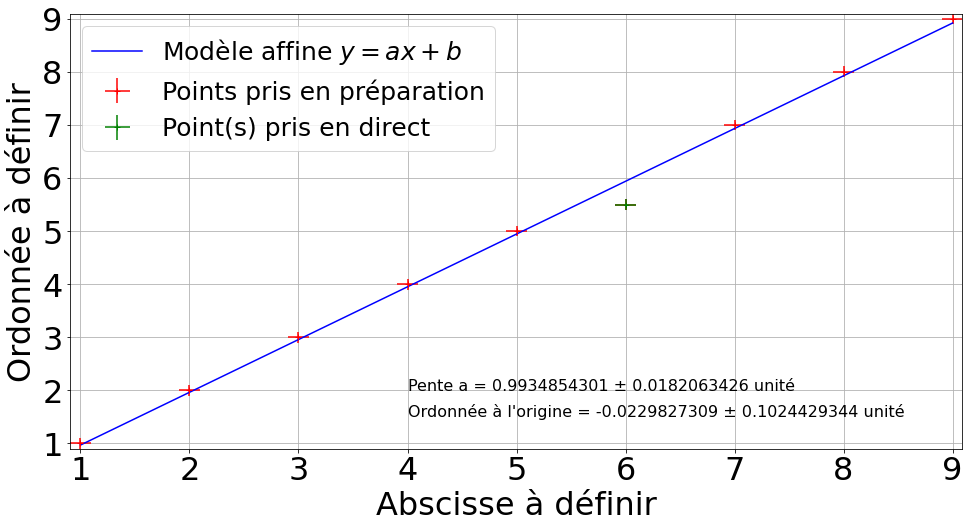

In [27]:
#Ici on fait juste le tracé. Rien à signaler de particulier. On créé une liste d'abscisse et d'ordonnée pour le 
#modèle.Sur cette manip, j'ai eu le problème que les graduations font n'importe quoi, d'où les 10**6 qui se balade
#partout, c'est juste là pour obtenirun graphe élégant.
#Ensuite, on trace en errorbar les points de mesure et le point expérimental (avec une couleur différente)
#Le reste c'est que de la déco pour obtenir un joli graphe (pensez bien à arrondir dans les fonction round() dont 
#le dernier argument est la décimale à laquelle il faut arrondir, pour éviter d'avoir 14 chiffres significatifs)

plt.figure(figsize=(16,8))
x_mod = np.linspace(np.amin(x),np.amax(x),1000)
y_mod = f(x_mod,popt)
plt.plot(x_mod,y_mod,label='Modèle affine $y = a x + b$', color = 'blue', linestyle= '-')
plt.errorbar(x,y,xerr=ux,yerr=uy,marker='+', color = 'red', linestyle= '',label='Points pris en préparation')
plt.errorbar(x_exp,y_exp,xerr=ux_exp,yerr=uy_exp,marker='+', color = 'green', linestyle= '',label='Point(s) pris en direct')
plt.xlabel('Abscisse à définir',fontsize=32)
plt.ylabel('Ordonnée à définir',fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.xlim(0.9*np.amin(x), 1.01*np.amax(x))
plt.ylim(0.9*np.amin(y), 1.01*np.amax(y))
plt.legend(loc='upper left',fontsize=25)
plt.text((np.amin(x)+np.amax(x))/2.5, np.amin(y) + (np.amin(y) + np.amax(y))/10 , 'Pente a = ' + str(round(popt[0],10)) + ' ± ' + str(round(upopt[0],10)) + ' unité',fontsize=16)
plt.text((np.amin(x)+np.amax(x))/2.5, np.amin(y) + (np.amin(y) + np.amax(y))/20, 'Ordonnée à l\'origine = ' + str(round(popt[1],10)) + ' ± ' + str(round(upopt[1],10)) + ' unité',fontsize=16)
plt.show()